# Введение
В данном блконоте представлено обучение моделей YOLO 11 и ResNet-101 на датасете Stanford Cars Dataset, а также их использование для предсказания марки и модели машины на видео.

Ссылка на датасет https://www.kaggle.com/datasets/rickyyyyyyy/torchvision-stanford-cars

Были использованы кадры из следующих видео:

https://www.youtube.com/watch?v=KrDJ0nfLQCU
https://www.youtube.com/watch?v=rvn4lHrr6AQ
https://www.youtube.com/watch?v=Xx1qXusvMSo

# Подготовка к обучению

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.9/896.9 kB 22.2 MB/s eta 0:00:00


## Установка необходимых библиотек и скачивание датасета

In [ ]:
import torch
import torchvision.datasets
import torchvision.transforms as transforms
import shutil
import os
import kagglehub
import matplotlib.pyplot as plt
from torchvision.datasets import StanfordCars
import pandas as pd
from ultralytics import YOLO
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.models import resnet101
from PIL import Image
import time
import cv2



In [ ]:
# Download latest version
path = kagglehub.dataset_download("rickyyyyyyy/torchvision-stanford-cars")

print("Path to dataset files:", path)

100%|██████████| 1.83G/1.83G [00:28<00:00, 68.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rickyyyyyyy/torchvision-stanford-cars/versions/2


## Содержимое датасета и изменение его структуры

Узнаем, какие модели и марки автомобилей есть в Stanford Cars Dataset, а также выведем их количество.

In [ ]:
dataset = torchvision.datasets.StanfordCars(
    root=path,  # Путь к загруженным данным
    split='train',  # Используем тренировочные данные
    download=False,  # Данные уже скачаны, не пытаться их загружать
    transform=torchvision.transforms.ToTensor()
)

# Вывод списка классов
class_names = dataset.classes
print("Всего классов:", len(class_names))
print("Примеры классов:")
for i, class_name in enumerate(class_names):  # Покажем первые 10 классов
    print(f"{i + 1}: {class_name}")

Всего классов: 196
Примеры классов:
1: AM General Hummer SUV 2000
2: Acura RL Sedan 2012
3: Acura TL Sedan 2012
4: Acura TL Type-S 2008
5: Acura TSX Sedan 2012
6: Acura Integra Type R 2001
7: Acura ZDX Hatchback 2012
8: Aston Martin V8 Vantage Convertible 2012
9: Aston Martin V8 Vantage Coupe 2012
10: Aston Martin Virage Convertible 2012
11: Aston Martin Virage Coupe 2012
12: Audi RS 4 Convertible 2008
13: Audi A5 Coupe 2012
14: Audi TTS Coupe 2012
15: Audi R8 Coupe 2012
16: Audi V8 Sedan 1994
17: Audi 100 Sedan 1994
18: Audi 100 Wagon 1994
19: Audi TT Hatchback 2011
20: Audi S6 Sedan 2011
21: Audi S5 Convertible 2012
22: Audi S5 Coupe 2012
23: Audi S4 Sedan 2012
24: Audi S4 Sedan 2007
25: Audi TT RS Coupe 2012
26: BMW ActiveHybrid 5 Sedan 2012
27: BMW 1 Series Convertible 2012
28: BMW 1 Series Coupe 2012
29: BMW 3 Series Sedan 2012
30: BMW 3 Series Wagon 2012
31: BMW 6 Series Convertible 2007
32: BMW X5 SUV 2007
33: BMW X6 SUV 2012
34: BMW M3 Coupe 2012
35: BMW M5 Sedan 2010
36: BMW M

Убедимся, что изображения соответствуют меткам.

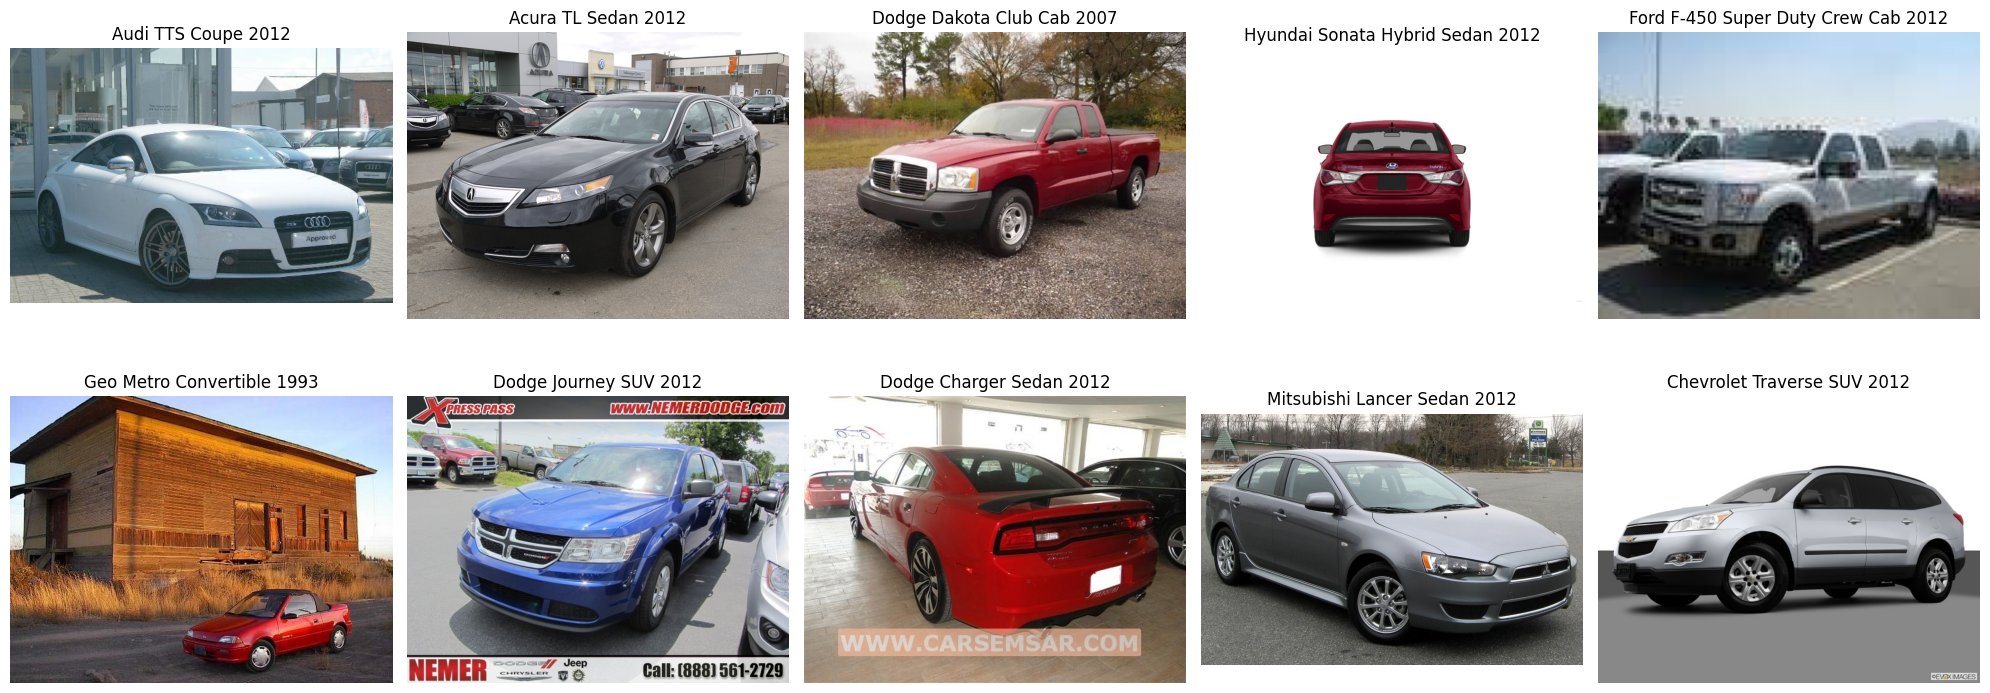

In [ ]:
# Вывод 10 картинок: 2 строки по 5 картинок
num_images = 10
images_per_row = 5

fig, axes = plt.subplots(2, images_per_row, figsize=(20, 8))
for idx in range(num_images):
    image, label = dataset[idx]  # Получаем изображение и метку класса
    row, col = divmod(idx, images_per_row)  # Рассчитываем позицию на сетке (строка, столбец)
    axes[row, col].imshow(image.permute(1, 2, 0))  # Меняем порядок осей для корректного отображения
    axes[row, col].set_title(class_names[label])  # Устанавливаем название класса
    axes[row, col].axis('off')  # Убираем оси

plt.tight_layout()
plt.show()


Изображения автомобилей и метки к ним совпадают.

Переделаем структуру файлов в исходном датасете для обучения моделей.

In [ ]:
# Папки для хранения данных
output_dir = "./data"
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Разделение данных по классам
for split in ["train", "test"]:
    dataset = StanfordCars(root=path, split=split, download=False)
    for idx, (image, label) in enumerate(dataset):
        class_name = class_names[label]
        split_dir = train_dir if split == "train" else val_dir
        class_dir = os.path.join(split_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

        # Сохраняем изображение
        image_path = os.path.join(class_dir, f"{idx}.jpg")
        image.save(image_path)


# Обучение моделей

## YOLO 11

Обучение будет происходить 25 эпох, так как этого достаточно для получения удовлетворительных показателей модели, а также не очень затратно по времени.

In [ ]:
# Инициализация модели YOLOv11 для классификации
model = YOLO("yolo11m-cls.pt")

# Обучение модели
model.train(
    data="./data",  # Путь к данным
    epochs=25,      # Количество эпох
    imgsz=224,      # Размер изображения
    batch=32,       # Размер батча
)


Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolo11m-cls.pt, data=./data, epochs=25, time=None, patience=100, batch=32, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_w

train: Scanning /content/data/train... 8144 images, 0 corrupt: 100%|██████████| 8144/8144 [00:00<?, ?it/s]
val: Scanning /content/data/val... 8041 images, 0 corrupt: 100%|██████████| 8041/8041 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 49 weight(decay=0.0), 50 weight(decay=0.0005), 50 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/train4
Starting training for 25 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:12<00:00,  1.74it/s]

                   all      0.257      0.546



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:10<00:00,  1.78it/s]

                   all      0.508      0.827



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:09<00:00,  1.81it/s]

                   all      0.561      0.853



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:09<00:00,  1.82it/s]

                   all      0.633      0.898



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:08<00:00,  1.83it/s]

                   all      0.715      0.933



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:07<00:00,  1.88it/s]

                   all      0.739      0.942



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:09<00:00,  1.80it/s]

                   all      0.773      0.955



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:10<00:00,  1.79it/s]

                   all      0.811      0.961



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:09<00:00,  1.82it/s]

                   all      0.825      0.961



      Epoch    GPU_mem       loss  Instances       Size


      10/25      1.64G     0.5131         16        224: 100%|██████████| 255/255 [01:35<00:00,  2.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:08<00:00,  1.83it/s]

                   all      0.827      0.969



      Epoch    GPU_mem       loss  Instances       Size


      11/25      1.65G     0.4595         16        224: 100%|██████████| 255/255 [01:36<00:00,  2.63it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:07<00:00,  1.86it/s]

                   all      0.833       0.97



      Epoch    GPU_mem       loss  Instances       Size


      12/25      1.64G     0.4041         16        224: 100%|██████████| 255/255 [01:35<00:00,  2.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:08<00:00,  1.85it/s]

                   all      0.849      0.973



      Epoch    GPU_mem       loss  Instances       Size


      13/25      1.65G     0.3335         16        224: 100%|██████████| 255/255 [01:34<00:00,  2.71it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:09<00:00,  1.82it/s]

                   all      0.853      0.976



      Epoch    GPU_mem       loss  Instances       Size


      14/25      1.64G     0.2946         16        224: 100%|██████████| 255/255 [01:33<00:00,  2.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:10<00:00,  1.79it/s]

                   all      0.865      0.975



      Epoch    GPU_mem       loss  Instances       Size


      15/25      1.65G     0.2733         16        224: 100%|██████████| 255/255 [01:34<00:00,  2.70it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:07<00:00,  1.86it/s]

                   all      0.873      0.977



      Epoch    GPU_mem       loss  Instances       Size


      16/25      1.64G     0.2533         16        224: 100%|██████████| 255/255 [01:37<00:00,  2.61it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:07<00:00,  1.86it/s]

                   all      0.871      0.979



      Epoch    GPU_mem       loss  Instances       Size


      17/25      1.65G     0.2321         16        224: 100%|██████████| 255/255 [01:32<00:00,  2.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:09<00:00,  1.81it/s]

                   all      0.878       0.98



      Epoch    GPU_mem       loss  Instances       Size


      18/25      1.64G     0.1925         16        224: 100%|██████████| 255/255 [01:33<00:00,  2.74it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:09<00:00,  1.81it/s]

                   all      0.883      0.983



      Epoch    GPU_mem       loss  Instances       Size


      19/25      1.65G     0.1807         16        224: 100%|██████████| 255/255 [01:34<00:00,  2.71it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:09<00:00,  1.82it/s]

                   all      0.886      0.982



      Epoch    GPU_mem       loss  Instances       Size


      20/25      1.64G     0.1629         16        224: 100%|██████████| 255/255 [01:34<00:00,  2.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:08<00:00,  1.84it/s]

                   all      0.888      0.981



      Epoch    GPU_mem       loss  Instances       Size


      21/25      1.65G     0.1584         16        224: 100%|██████████| 255/255 [01:35<00:00,  2.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:09<00:00,  1.82it/s]

                   all      0.892      0.982



      Epoch    GPU_mem       loss  Instances       Size


      22/25      1.64G     0.1302         16        224: 100%|██████████| 255/255 [01:33<00:00,  2.71it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:10<00:00,  1.80it/s]

                   all      0.894      0.984



      Epoch    GPU_mem       loss  Instances       Size


      23/25      1.65G     0.1243         16        224: 100%|██████████| 255/255 [01:35<00:00,  2.66it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:09<00:00,  1.83it/s]

                   all      0.896      0.983



      Epoch    GPU_mem       loss  Instances       Size


      24/25      1.64G     0.1149         16        224: 100%|██████████| 255/255 [01:35<00:00,  2.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:09<00:00,  1.82it/s]

                   all        0.9      0.985



      Epoch    GPU_mem       loss  Instances       Size


      25/25      1.65G    0.09977         16        224: 100%|██████████| 255/255 [01:33<00:00,  2.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:09<00:00,  1.81it/s]

                   all      0.901      0.985



25 epochs completed in 1.165 hours.
Optimizer stripped from runs/classify/train4/weights/last.pt, 21.4MB
Optimizer stripped from runs/classify/train4/weights/best.pt, 21.4MB

Validating runs/classify/train4/weights/best.pt...
Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11m-cls summary (fused): 138 layers, 10,592,708 parameters, 0 gradients, 39.5 GFLOPs
train: /content/data/train... found 8144 images in 196 classes ✅ 
val: /content/data/val... found 8041 images in 196 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:09<00:00,  1.81it/s]


                   all      0.901      0.985
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train4


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d3b801ac250>
curves: []
curves_results: []
fitness: 0.9428553879261017
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.901007354259491, 'metrics/accuracy_top5': 0.9847034215927124, 'fitness': 0.9428553879261017}
save_dir: PosixPath('runs/classify/train4')
speed: {'preprocess': 0.07364346959996826, 'inference': 0.7914058487001098, 'loss': 0.00028909105164037237, 'postprocess': 0.00023266640843302587}
task: 'classify'
top1: 0.901007354259491
top5: 0.9847034215927124

Из отладочной информации видно, что обучение заняло чуть больше 1-го часа.

Выведем в виде графика, как изменялись потери и accuracy в процессе обучения.

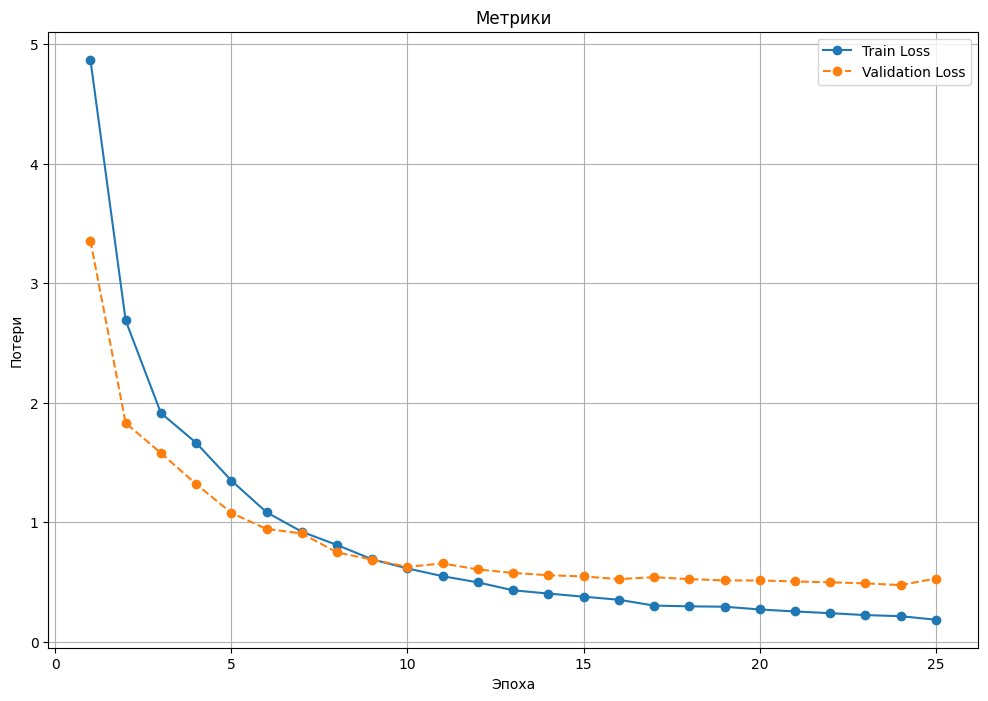

In [ ]:

# Загрузка данных из CSV
file_path = "/content/runs/classify/train/results.csv"
data = pd.read_csv(file_path)


# Построение графиков
plt.figure(figsize=(12, 8))

# График Loss
plt.plot(data["epoch"], data["train/loss"], label="Train Loss", marker='o', linestyle='-')
plt.plot(data["epoch"], data["val/loss"], label="Validation Loss", marker='o', linestyle='--')

# Оформление
plt.title("Метрики")
plt.xlabel("Эпоха")
plt.ylabel("Потери")
plt.legend()
plt.grid(True)

# Показ графика
plt.show()


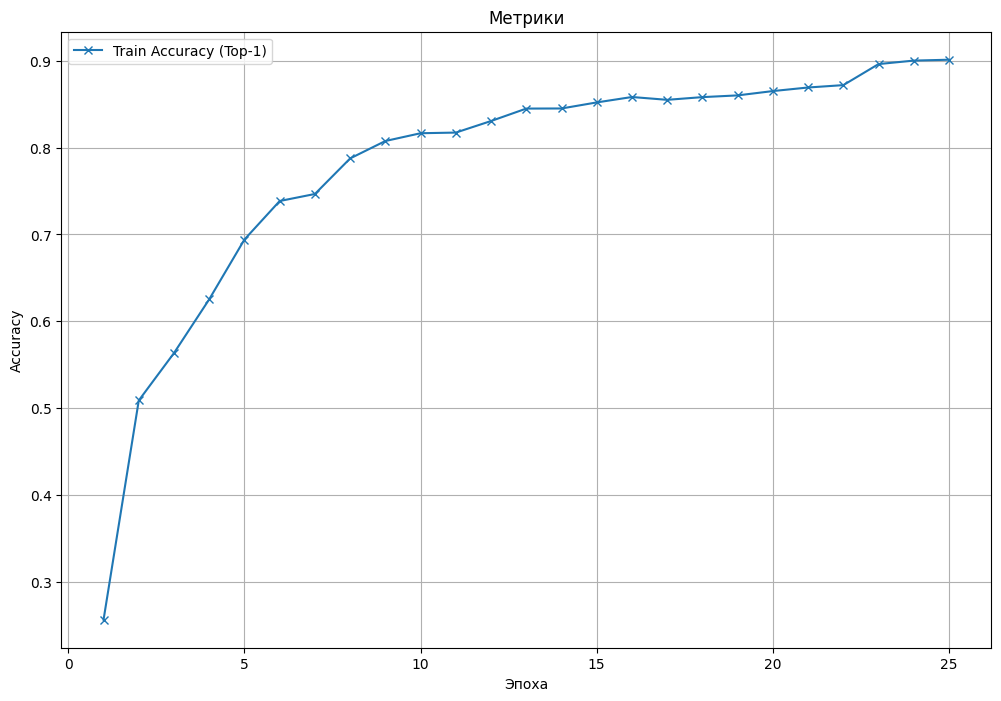

In [ ]:
plt.figure(figsize=(12, 8))
# График Accuracy
plt.plot(data["epoch"], data["metrics/accuracy_top1"], label="Train Accuracy (Top-1)", marker='x', linestyle='-')
# Оформление
plt.title("Метрики")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Показ графика
plt.show()

По графикам можно сказать, что для достижения удовлетворительных показателей YOLO 11 вполне достаточно и 10 эпох (особенно, если времени на обучение нужно как можно меньше)

Сохраним файл с лучшей моделью в корневую папку.

In [ ]:
# Исходный путь к модели
source_path = "/content/runs/classify/train/weights/best.pt"  # Укажите актуальный путь к вашей модели

# Путь назначения
destination_path = "/content/yolo11_model_cars.pt"

# Проверяем, существует ли исходный файл
if os.path.exists(source_path):
    # Перемещаем и переименовываем
    shutil.move(source_path, destination_path)
else:
    print(f"Файл {source_path} не найден!")

## ResNet-101

Обучение ResNet-101 так же будет производиться в течение 25 эпох, чтобы сравнить время обучения и полученные метрики с YOLO 11.

In [ ]:
# Устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Преобразования данных
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),  # Размер для входа в ResNet
        transforms.RandomHorizontalFlip(),  # Аугментация
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Нормализация
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Путь к данным
data_dir = "./data"

# Загрузка данных
datasets_dict = {
    phase: datasets.ImageFolder(root=f"{data_dir}/{phase}", transform=data_transforms[phase])
    for phase in ["train", "val"]
}
dataloaders = {
    phase: DataLoader(datasets_dict[phase], batch_size=32, shuffle=True, num_workers=4)
    for phase in ["train", "val"]
}

# Убедимся, что датасет верно считался, выведя количество классов
num_classes = len(datasets_dict["train"].classes)
print("Количество классов:", num_classes)


Количество классов: 196


In [ ]:
# Загрузка предобученной модели ResNet-101
model = models.resnet101(pretrained=True)

# Замена финального слоя для нашего количества классов
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Перенос модели на устройство
model = model.to(device)


In [ ]:
# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# scheduler для уменьшения learning rate при плато
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    # Списки для хранения значений loss и accuracy
    history = {
        "epoch": [],
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Включить обучение
            else:
                model.eval()   # Включить оценку

            running_loss = 0.0
            running_corrects = 0

            # Итерация по данным
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Сохранение результатов
            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc.item())
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc.item())

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        history["epoch"].append(epoch + 1)

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:.4f}")

    # Загружаем лучшие веса
    model.load_state_dict(best_model_wts)

    return model, history


# Обучение модели
model, history = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25)

# Создание DataFrame из словаря history
history_df = pd.DataFrame(history)

# Сохранение в CSV файл
history_df.to_csv("/content/training_history_resnet.csv", index=False)

# Проверка сохранённых данных
print("История обучения:", history)

torch.save(model.state_dict(), "resnet101_stanford_cars.pth")
print("Модель сохранена!")

Epoch 1/25
----------
train Loss: 3.9492 Acc: 0.1916
val Loss: 2.4192 Acc: 0.4278
Epoch 2/25
----------
train Loss: 1.7405 Acc: 0.6093
val Loss: 1.4756 Acc: 0.6114
Epoch 3/25
----------
train Loss: 0.7999 Acc: 0.8183
val Loss: 1.0145 Acc: 0.7172
Epoch 4/25
----------
train Loss: 0.4026 Acc: 0.9093
val Loss: 0.7792 Acc: 0.7809
Epoch 5/25
----------
train Loss: 0.2367 Acc: 0.9514
val Loss: 0.7199 Acc: 0.7952
Epoch 6/25
----------
train Loss: 0.1529 Acc: 0.9691
val Loss: 0.6173 Acc: 0.8268
Epoch 7/25
----------
train Loss: 0.1136 Acc: 0.9790
val Loss: 0.6932 Acc: 0.8087
Epoch 8/25
----------
train Loss: 0.1112 Acc: 0.9774
val Loss: 0.7175 Acc: 0.8028
Epoch 9/25
----------
train Loss: 0.1035 Acc: 0.9805
val Loss: 0.7218 Acc: 0.8033
Epoch 10/25
----------
train Loss: 0.0865 Acc: 0.9807
val Loss: 0.8599 Acc: 0.7712
Epoch 11/25
----------
train Loss: 0.1096 Acc: 0.9732
val Loss: 0.8874 Acc: 0.7657
Epoch 12/25
----------
train Loss: 0.0912 Acc: 0.9774
val Loss: 0.7533 Acc: 0.7967
Epoch 13/25
-

Обучение заняло 1 час и 30 минут, что больше, чем у YOLO.

Используем csv файл с данными об изменении метрик в процессе обучения для построения графика.

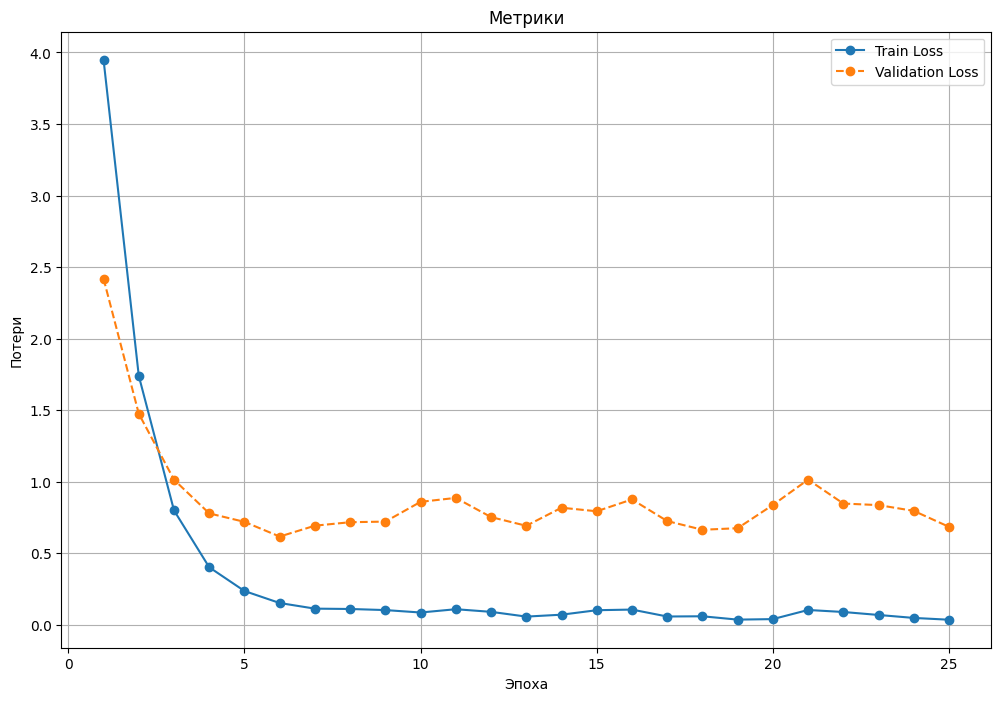

In [ ]:
# Загрузка данных из CSV
file_path = "/content/training_history_resnet.csv"  # Укажите путь к вашему файлу
data = pd.read_csv(file_path)


# Построение графиков
plt.figure(figsize=(12, 8))

# График Loss
plt.plot(data["epoch"], data["train_loss"], label="Train Loss", marker='o', linestyle='-')
plt.plot(data["epoch"], data["val_loss"], label="Validation Loss", marker='o', linestyle='--')

# Оформление
plt.title("Метрики")
plt.xlabel("Эпоха")
plt.ylabel("Потери")
plt.legend()
plt.grid(True)

# Показ графика
plt.show()


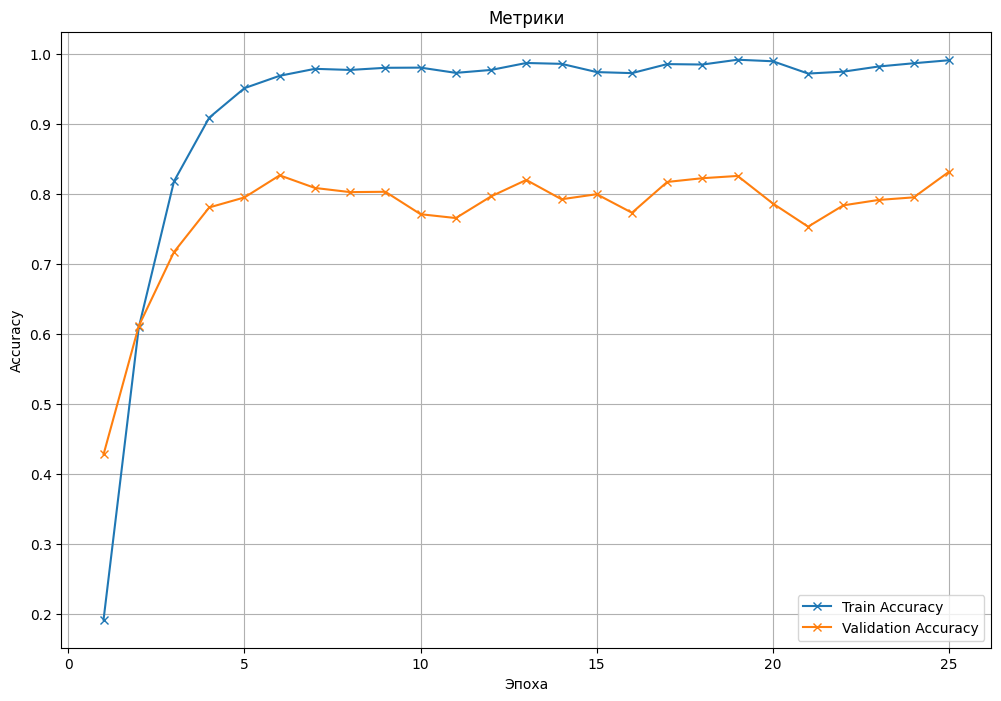

In [ ]:
plt.figure(figsize=(12, 8))
# График Accuracy
plt.plot(data["epoch"], data["train_acc"], label="Train Accuracy", marker='x')
plt.plot(data["epoch"], data["val_acc"], label="Validation Accuracy", marker='x')
# Оформление
plt.title("Метрики")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Показ графика
plt.show()

Если сравнивать полученные loss и accuracy, то accuracy у YOLO немного выше, а loss примерно одинаковые у обеих моделей.

# Классификация

## Классификация на картинках

Предскажем класс автомобиля Volkswagen Golf Hatchback 2012, класс которого есть в датасете. А также выведем вероятность предсказания. Начнём с YOLO 11.


image 1/1 /content/golf.jpg: 224x224 Volkswagen Golf Hatchback 2012 0.98, Hyundai Elantra Touring Hatchback 2012 0.02, Mercedes-Benz C-Class Sedan 2012 0.00, Daewoo Nubira Wagon 2002 0.00, BMW 1 Series Coupe 2012 0.00, 5.8ms
Speed: 2.9ms preprocess, 5.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


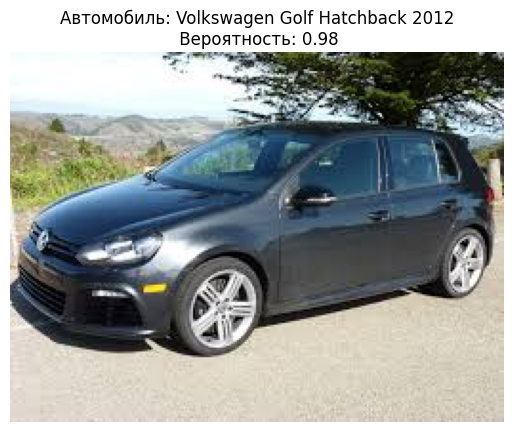

In [ ]:

# Загрузим модель YOLO
yolo_model_test = YOLO("/content/yolo11_model_cars.pt")

# Выполним инференс
results = yolo_model_test('/content/golf.jpg')

# Обрабатываем результат
for result in results:
    # Получаем вероятности предсказания
    class_probs = result.probs  # Probs объект
    class_names = yolo_model_test.names  # Список названий классов

    if class_probs is not None:
        # Используем встроенные атрибуты Probs для получения топового предсказания
        class_id = class_probs.top1  # Индекс предсказанного класса
        confidence = class_probs.top1conf.item()  # Уверенность модели
        class_label = class_names[class_id]  # Название класса

        # Загружаем оригинальное изображение
        img = cv2.imread('/content/golf.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Преобразуем в RGB для отображения

        # Выводим результат
        plt.imshow(img)
        plt.title(f"Автомобиль: {class_label}\n Вероятность: {confidence:.2f}")
        plt.axis('off')
        plt.show()
    else:
        print("No class probabilities found.")

Ответ верный. Выведем предсказание ResNet-101.

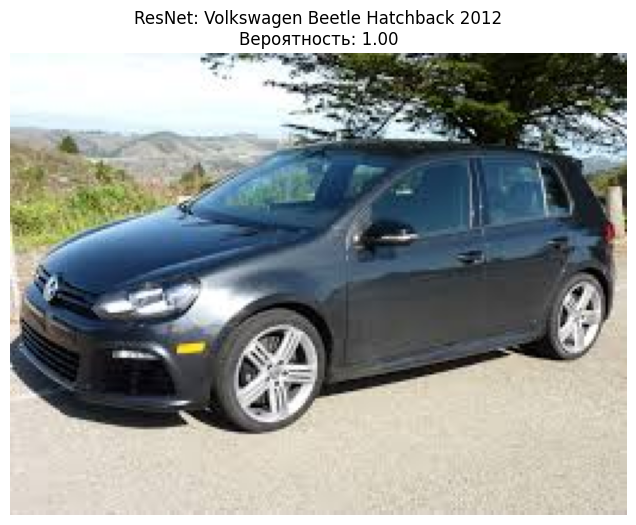

In [ ]:
resnet_model_path = "/content/resnet101_stanford_cars.pth"
image_path = "/content/golf.jpg"

# Загрузка изображения
image = Image.open(image_path).convert("RGB")
img_cv2 = cv2.imread(image_path)
img_cv2 = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)  # Для отображения в RGB

# Предобработка изображения для ResNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_image = transform(image).unsqueeze(0)  # Добавляем batch dimension

# Создание модели ResNet и загрузка весов
resnet_model = resnet101(pretrained=False, num_classes=len(class_names))  # Указываем количество классов
resnet_model.load_state_dict(torch.load(resnet_model_path))  # Загрузка весов
resnet_model.eval()  # Устанавливаем модель в режим оценки

# Выполнение предсказания ResNet
with torch.no_grad():
    resnet_output = resnet_model(input_image)
    probabilities = torch.softmax(resnet_output, dim=1)  # Преобразуем выход в вероятности
    resnet_prediction = torch.argmax(probabilities, 1).item()  # Индекс класса
    resnet_label = class_names[resnet_prediction]  # Название класса
    confidence = probabilities[0, resnet_prediction].item()  # Вероятность предсказанного класса

# Вывод результата ResNet
plt.figure(figsize=(12, 6))
plt.imshow(img_cv2)
plt.title(f"ResNet: {resnet_label}\nВероятность: {confidence:.2f}")
plt.axis("off")
plt.show()

Ответ так же верен, но вероятность немного выше.

## Классификация на видео

Исходное видео содержит отрезки с тремя автомобилями.

Классификация на видео будет произведена следующим образом - видео будет поделено на кадры, на каждом кадре будет предсказан автомобиль, а затем эти кадры будут склеены в результирующее видео.

На каждом кадре будет выводиться предсказанный класс автомобился и вероятность предсказания. Код для YOLO 11:

In [ ]:
# Пути к модели и видео
yolo_model_path = "/content/yolo11_model_cars.pt"
video_path = "/content/machinki.mp4"
output_path = "/content/machinki_processed_yolo.mp4"

# Загрузка модели YOLO (отключаем подробный вывод)
yolo_model = YOLO(yolo_model_path)

# Открываем видео
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Создаём объект для записи видео
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Засекаем время начала обработки
start_time = time.time()

# Обрабатываем видео покадрово
frame_count = 0
while cap.isOpened():
    print(frame_count)
    ret, frame = cap.read()
    if not ret:
        break

    # Выполняем предсказание YOLO
    results = yolo_model(frame)

    for result in results:
        class_probs = result.probs  # Probs объект
        if class_probs is not None:
            # Используем встроенные атрибуты Probs для получения предсказания
            class_id = class_probs.top1  # Индекс предсказанного класса
            confidence = class_probs.top1conf.item()  # Уверенность модели
            class_label = yolo_model.names[class_id]  # Название класса

            # Добавляем текст на кадр
            text = f"{frame_count} {class_label}: {confidence:.2f}"
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 1
            thickness = 2

            # Размер текста
            text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]
            text_width, text_height = text_size
            text_offset_x, text_offset_y = 10, 30
            box_coords = ((text_offset_x, text_offset_y - text_height - 5),
                          (text_offset_x + text_width + 5, text_offset_y + 5))

            # Рисуем белый прямоугольник
            cv2.rectangle(frame, box_coords[0], box_coords[1], (255, 255, 255), cv2.FILLED)

            # Рисуем чёрный текст
            cv2.putText(frame, text, (text_offset_x, text_offset_y), font, font_scale, (0, 0, 0), thickness, cv2.LINE_AA)

    # Записываем кадр в выходное видео
    out.write(frame)
    frame_count += 1

# Освобождаем ресурсы
cap.release()
out.release()

# Засекаем время завершения обработки
end_time = time.time()

# Вывод времени обработки
total_time = end_time - start_time
print(f"Обработка завершена. Обработано {frame_count} кадров за {total_time:.2f} секунд.")
print(f"Обработанное видео сохранено в: {output_path}")

0

0: 224x224 Jaguar XK XKR 2012 0.40, Tesla Model S Sedan 2012 0.12, Hyundai Tucson SUV 2012 0.09, Bentley Continental Supersports Conv. Convertible 2012 0.07, Suzuki Kizashi Sedan 2012 0.05, 5.8ms
Speed: 17.4ms preprocess, 5.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
1

0: 224x224 Jaguar XK XKR 2012 0.60, Tesla Model S Sedan 2012 0.11, Bentley Continental Supersports Conv. Convertible 2012 0.06, Bentley Continental GT Coupe 2007 0.04, Hyundai Tucson SUV 2012 0.04, 6.0ms
Speed: 24.9ms preprocess, 6.0ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
2

0: 224x224 Jaguar XK XKR 2012 0.74, Tesla Model S Sedan 2012 0.09, Bentley Continental GT Coupe 2007 0.03, Bentley Continental Supersports Conv. Convertible 2012 0.03, Bugatti Veyron 16.4 Coupe 2009 0.02, 6.0ms
Speed: 22.1ms preprocess, 6.0ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
3

0: 224x224 Jaguar XK XKR 2012 0.75, Tesla Model S Sedan 2012 0.09, Bentley Continental

Всего 807 кадров, которые были обработаны за 57 секунд. Код для ResNet-101.

In [ ]:
# Пути к модели и видео
resnet_model_path = "/content/resnet101_stanford_cars.pth"
video_path = "/content/machinki.mp4"
output_path = "/content/machinki_processed_resnet.mp4"

# Загрузка ResNet модели
resnet_model = resnet101(pretrained=False, num_classes=len(class_names))  # Указываем количество классов
resnet_model.load_state_dict(torch.load(resnet_model_path))  # Загрузка весов
resnet_model.eval()  # Устанавливаем модель в режим оценки


# Преобразования для ResNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Открываем видео
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Создаём объект для записи видео
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Засекаем время начала обработки
start_time = time.time()

# Обрабатываем видео покадрово
frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Преобразуем изображение в формат, подходящий для ResNet
    img_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    input_image = transform(img_pil).unsqueeze(0)  # Добавляем batch dimension

    # Выполнение предсказания ResNet
    with torch.no_grad():
        resnet_output = resnet_model(input_image)
        resnet_prediction = torch.argmax(resnet_output, 1).item()
        resnet_label = class_names[resnet_prediction]
        confidence = torch.softmax(resnet_output, dim=1)[0][resnet_prediction].item()

    # Добавляем текст на кадр
    text = f"{resnet_label}: {confidence:.2f}"
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    thickness = 2

    # Размер текста
    text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]
    text_width, text_height = text_size
    text_offset_x, text_offset_y = 10, 30
    box_coords = ((text_offset_x, text_offset_y - text_height - 5),
                  (text_offset_x + text_width + 5, text_offset_y + 5))

    # Рисуем белый прямоугольник
    cv2.rectangle(frame, box_coords[0], box_coords[1], (255, 255, 255), cv2.FILLED)

    # Рисуем чёрный текст
    cv2.putText(frame, text, (text_offset_x, text_offset_y), font, font_scale, (0, 0, 0), thickness, cv2.LINE_AA)

    # Записываем кадр в выходное видео
    out.write(frame)
    frame_count += 1

# Освобождаем ресурсы
cap.release()
out.release()

# Засекаем время завершения обработки
end_time = time.time()

# Вывод времени обработки
total_time = end_time - start_time
print(f"Обработка завершена. Обработано {frame_count} кадров за {total_time:.2f} секунд.")
print(f"Обработанное видео сохранено в: {output_path}")

Обработка завершена. Обработано 807 кадров за 206.09 секунд.
Обработанное видео сохранено в: /content/machinki_processed_resnet.mp4


Намного медленнее, чем YOLO. Если же посмотреть видео, то можно замметить, что предсказания часто неверны. Убедимся в этом добавив на видео количество ошибок для каждой из моделей.

In [ ]:
import cv2
import time
import torch
from PIL import Image
from torchvision import transforms
import torchvision.models as models

# Пути к модели и видео
yolo_model_path = "/content/yolo11_model_cars.pt"
resnet_model_path = "/content/resnet101_stanford_cars.pth"
video_path = "/content/machinki.mp4"
output_path = "/content/machinki_processed_both_models.mp4"

resnet_model = resnet101(pretrained=False, num_classes=len(class_names))  # Указываем количество классов
resnet_model.load_state_dict(torch.load(resnet_model_path))  # Загрузка весов
resnet_model.eval()  # Устанавливаем модель в режим оценки



# Загрузка модели YOLO
yolo_model = YOLO(yolo_model_path)

# Преобразования для ResNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Открываем видео
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Создаём объект для записи видео
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Засекаем время начала обработки
start_time = time.time()

# Инициализация переменных для подсчета ошибок
yolo_error = 0
resnet_error = 0
target_class = class_names[103]  # Изначально

# Обрабатываем видео покадрово
frame_count = 0
while cap.isOpened():
    if frame_count > 240 and frame_count < 528:
        target_class = class_names[45]
    if frame_count > 527:
        target_class = class_names[184]

    ret, frame = cap.read()
    if not ret:
        break

    # Выполняем предсказание YOLO
    results = yolo_model(frame)
    yolo_pred_class = None
    yolo_confidence = 0
    for result in results:
        class_probs = result.probs
        if class_probs is not None:
            # Получаем результат предсказания
            class_id = class_probs.top1
            confidence = class_probs.top1conf.item()
            class_label = yolo_model.names[class_id]

            # Проверка ошибки YOLO
            if class_label != target_class:
                yolo_error += 1

            yolo_pred_class = class_label
            yolo_confidence = confidence

    # Выполнение предсказания для ResNet
    img_pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    input_image = transform(img_pil).unsqueeze(0)
    with torch.no_grad():
        resnet_output = resnet_model(input_image)
        resnet_prediction = torch.argmax(resnet_output, 1).item()
        resnet_label = class_names[resnet_prediction]
        confidence_resnet = torch.softmax(resnet_output, dim=1)[0][resnet_prediction].item()

        # Проверка ошибки ResNet
        if resnet_label != target_class:
            resnet_error += 1

    # Формирование текста для отображения
    text_yolo = f"YOLO: {yolo_pred_class} {yolo_confidence:.2f}"
    text_yolo_errors = f"YOLO errors: {yolo_error}"
    text_resnet = f"ResNet: {resnet_label} {confidence_resnet:.2f}"
    text_resnet_errors = f"ResNet errors: {resnet_error}"

    # Рисуем прямоугольники для текста
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    thickness = 2

    # Вычисляем размер текста для каждой строки
    text_size_1 = cv2.getTextSize(text_yolo, font, font_scale, thickness)[0]
    text_size_2 = cv2.getTextSize(text_yolo_errors, font, font_scale, thickness)[0]
    text_size_3 = cv2.getTextSize(text_resnet, font, font_scale, thickness)[0]
    text_size_4 = cv2.getTextSize(text_resnet_errors, font, font_scale, thickness)[0]

    # Отступы для текста
    text_offset_x, text_offset_y = 10, 30
    box_coords_1 = ((text_offset_x, text_offset_y - text_size_1[1] - 5),
                    (text_offset_x + text_size_1[0] + 5, text_offset_y + 5))
    box_coords_2 = ((text_offset_x, text_offset_y + text_size_1[1] + 10),
                    (text_offset_x + text_size_2[0] + 5, text_offset_y + text_size_2[1] + 15))
    box_coords_3 = ((text_offset_x, text_offset_y + text_size_1[1] + text_size_2[1] + 20),
                    (text_offset_x + text_size_3[0] + 5, text_offset_y + text_size_3[1] + 25))
    box_coords_4 = ((text_offset_x, text_offset_y + text_size_1[1] + text_size_2[1] + text_size_3[1] + 30),
                    (text_offset_x + text_size_4[0] + 5, text_offset_y + text_size_4[1] + 35))

    # Прямоугольники для текста
    cv2.rectangle(frame, box_coords_1[0], box_coords_1[1], (255, 255, 255), cv2.FILLED)
    cv2.rectangle(frame, box_coords_2[0], box_coords_2[1], (255, 255, 255), cv2.FILLED)
    cv2.rectangle(frame, box_coords_3[0], box_coords_3[1], (255, 255, 255), cv2.FILLED)
    cv2.rectangle(frame, box_coords_4[0], box_coords_4[1], (255, 255, 255), cv2.FILLED)

    # Рисуем текст
    cv2.putText(frame, text_yolo, (text_offset_x, text_offset_y), font, font_scale, (0, 0, 0), thickness, cv2.LINE_AA)
    cv2.putText(frame, text_yolo_errors, (text_offset_x, text_offset_y + text_size_1[1] + 10), font, font_scale, (0, 0, 0), thickness, cv2.LINE_AA)
    cv2.putText(frame, text_resnet, (text_offset_x, text_offset_y + text_size_1[1] + text_size_2[1] + 20), font, font_scale, (0, 0, 0), thickness, cv2.LINE_AA)
    cv2.putText(frame, text_resnet_errors, (text_offset_x, text_offset_y + text_size_1[1] + text_size_2[1] + text_size_3[1] + 30), font, font_scale, (0, 0, 0), thickness, cv2.LINE_AA)

    # Записываем кадр в выходное видео
    out.write(frame)
    frame_count += 1

# Освобождаем ресурсы
cap.release()
out.release()

# Засекаем время завершения обработки
end_time = time.time()

# Вывод времени обработки
total_time = end_time - start_time
print(f"Обработка завершена. Обработано {frame_count} кадров за {total_time:.2f} секунд.")
print(f"Обработанное видео сохранено в: {output_path}")



0: 224x224 Jaguar XK XKR 2012 0.40, Tesla Model S Sedan 2012 0.12, Hyundai Tucson SUV 2012 0.09, Bentley Continental Supersports Conv. Convertible 2012 0.07, Suzuki Kizashi Sedan 2012 0.05, 10.5ms
Speed: 42.6ms preprocess, 10.5ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 Jaguar XK XKR 2012 0.60, Tesla Model S Sedan 2012 0.11, Bentley Continental Supersports Conv. Convertible 2012 0.06, Bentley Continental GT Coupe 2007 0.04, Hyundai Tucson SUV 2012 0.04, 20.8ms
Speed: 78.2ms preprocess, 20.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 Jaguar XK XKR 2012 0.74, Tesla Model S Sedan 2012 0.09, Bentley Continental GT Coupe 2007 0.03, Bentley Continental Supersports Conv. Convertible 2012 0.03, Bugatti Veyron 16.4 Coupe 2009 0.02, 33.6ms
Speed: 76.8ms preprocess, 33.6ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 Jaguar XK XKR 2012 0.75, Tesla Model S Sedan 2012 0.09, Bentley Continental G

# Выводы

Таким образом, путём сравнения между собой YOLO 11 для классификации и ResNet-101 можно сказать, что YOLO показала себя лучше по всем характеристикам: метрики, время обучения и время обработки видео. Одно из применений полученной модели - поиск угнанной машины с изменённым номером.